### 2-1. 顧客の行動 Pattern の類似度を計算しよう
顧客の行動 Pattern を把握するためには、その行動 Pattern を数値化する必要がある。
数値化できれば、類似度の違いで計算できる。

> #### 類似度
> 似ている度合い

> #### 特徴 Vector
> 評価したい対象を数値化したもの。
> ※類似度も特徴 Vector といえる

#### 機械学習と特徴 Vector の関係
評価したい対象を「特徴 Vector」とする。

| 種類         | 関係                                                                     |
|------------|------------------------------------------------------------------------|
| Clustering | 同じような特徴 Vector を持つものを分類すること                                            |
| 分類         | 特徴 Vector が、すでに何らかの方法で分類がなされているものに対して、その原因を分析し、新たな対象がどの分類になされるかを予測すること |
| 回帰         | 特徴 Vector が時系列であった場合に、その時系列 Pattern の傾向を予測すること                         |

In [2]:
# Data を読み込む
import pandas as pd
df_info = pd.read_csv('accomodation_info.csv', index_col=0, parse_dates=[0])
display(df_info)

,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:02:21,110034,若松 花子,B,19000
2018-11-01 00:03:10,112804,津田 美加子,D,20000
2018-11-01 00:06:19,110275,吉本 美加子,D,20000
2018-11-01 00:08:41,110169,坂本 直人,B,19000
2018-11-01 00:12:22,111504,青山 零,A,15000
...,...,...,...,...
2020-10-31 23:38:51,110049,吉本 篤司,A,3000
2020-10-31 23:42:12,110127,喜嶋 浩,A,3000
2020-10-31 23:47:24,115464,藤本 明美,D,8000


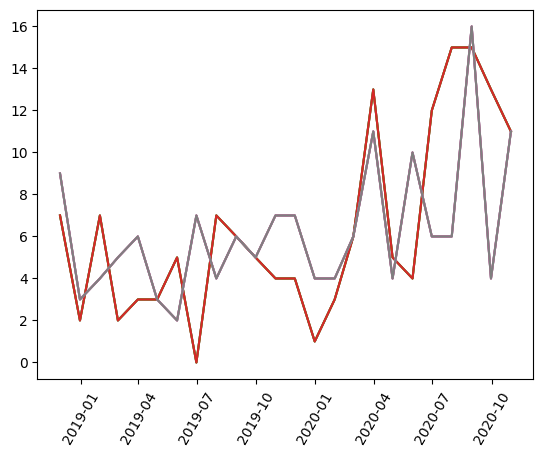

In [3]:
# 特徴 Vector を可視化する
import matplotlib.pyplot as plt

# index の抽出
x_0 = df_info.resample('M').count()
x_0 = x_0.drop(x_0.columns.values, axis=1)

# 順位の設定
i_rank = 1
j_rank = 2
# それぞれの値を変えることで、様々な順位の宿泊者（顧客）の特徴Vector を可視化・類似度計算できる

# 顧客ID の抽出
i_id = df_info['顧客ID'].value_counts().index[i_rank]
j_id = df_info['顧客ID'].value_counts().index[j_rank]

# 月毎の利用回数を特徴量として抽出
# 毎月の利用回数を24次元Vector (24個の数値)とする
x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 最も利用回数が多い宿泊者
x_j = df_info[df_info['顧客ID'] == j_id].resample('M').count()  # 次に利用回数が多い宿泊者

# 欠損値があった場合の穴埋め
x_i = pd.concat([x_0, x_i], axis=1).fillna(0)
x_j = pd.concat([x_0, x_j], axis=1).fillna(0)

# 描画
# 時系列で重ねて Graph に描画することで、それぞれの特徴Vector がどのようなものであるか把握する
plt.plot(x_i)
plt.plot(x_j)
plt.xticks(rotation=60)
plt.show()

In [4]:
# 類似度を計算する
# 特徴Vector である x_i と x_j との距離を次元数で割ったものを「類似度」と定義する。
import numpy as np

# 特徴Vector の差を計算
dx = x_i.iloc[:, 0].values - x_j.iloc[:, 0].values
# Vector-norm (距離)を計算
n = np.linalg.norm(dx)

# 次元による正規化
num_dim = len(x_i)
d = n / num_dim

print('類似度:', d)  # 0 に近いほど類似性が近いと考える。

類似度: 0.798218502527834


「類似度」は数値が大きいほど類似性が高いとする場合が多いが、計算を簡単にするため「距離」を次元数で割ったものを「類似度」と定義。

> *類似度を計算する方法*
> 相関関係を計算する式である相関係数など様々あり、どのような類似性を計算したいかにより使い分ける。

### 2-2. 類似度と機械学習との関係を知ろう
顧客行動Pattern の分析対象と対応機械学習の種類

| 分析対象                                                 | 機械学習の種類             |
|------------------------------------------------------|---------------------|
| 顧客には、どのような行動Pattern があるか。<br>（どんな Pattern の大口顧客がいるか） | Clustering (教師なし学習) |
| ある顧客が大口顧客になり得るかどうかを予測したい。<br>（あるいは、その原因をしりたい）        | 分類（教師あり学習）          |
| 大口顧客の今後の動向を予測したい。                                    | 回帰（教師あり学習）          |

上記にいたる Process として、まず
1. 特徴Vector の定義（数値化）
2. 多次元の特徴Vector を2次元に**次元削除**

を行ない全体像がわかるように可視化する。

こうして可視化されたいくつかの Sample を
- **「Clustering」** し行動Pattern を分類する。
- 何らかの方法で分類されたその原因を分析したり、その原因から新たな Sample がどの分類がなされるべきかを予測する目的で *「分類」* を行なう。
- 時系列Pattern から今後の動向の予測を **「回帰」**で行なう。

### 2-3. 大口顧客の類似性を主成分分析によって確認しよう

In [6]:
# 特徴 Vector を抽出する
import pandas as pd

# index の調整
x_0 = df_info.resample('M').count()
x_0 = x_0.drop(x_0.columns.values, axis=1)

# 配列を準備
list_vector = []

# 人数の設定
num = 100
for i_rank in range(num):  # 顧客ID の抽出
    i_id = df_info['顧客ID'].value_counts().index[i_rank]  # 月ごとの利用回数を特徴量として抽出
    x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 欠損値があった場合の穴埋め
    x_i = pd.concat([x_0, x_i], axis=1).fillna(0)  # 特徴Vector として追加
    list_vector.append(x_i.iloc[:, 0].values.tolist())

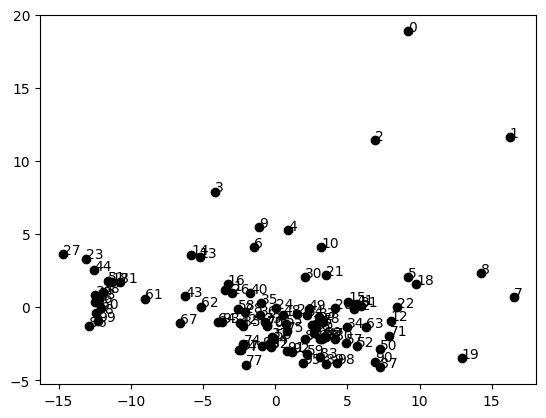

In [7]:
# 主成分分析を行なう
from sklearn.decomposition import PCA
import numpy
import matplotlib.pyplot as plt

features = np.array(list_vector)  # 特徴Vector を変換
# 主成分分析を実施
pca = PCA()
pca.fit(features)
# 特徴Vector を主成分に変換
transformed = pca.fit_transform(features)
# 可視化
for i in range(len(transformed)):
    plt.scatter(transformed[i, 0], transformed[i, 1], color='k')
    plt.text(transformed[i, 0], transformed[i, 1], str(i))
plt.show()